# Summary of Analysis

This analysis involved developing a machine learning model trained on a payments data set, where each row is an individual payment (50,000 rows), across 203 banks and 173 customers. Various features were available:

* `id`: a unique transaction identifier. Can be excluded from the model.
* `bank_id`: Identifies the bank involved in the transaction. This could be useful for analysis if different banks have varying outcomes, but this was excluded due to high cardinality. In future work, a hierarchical model would be appropriate to account for the bank level.
* `customer_id`: Identifies unique customers. Again including this in the model would result in high cardinality and was therefore excluded, a hierarchical modelling approach would be best suited to account for the customer level.
* `currency`: The currency of the transaction. Due to sparse counts, Euros and GBP categories were combined. USD appears to be the currency with the lowest chances of the payment succeeding, followed by EURO/GBP combined.
* `status`: The current status of the payment (e.g., 'completed', 'pending', 'failed'). This was used to derive the target `outcome`. Statuses that were not complete was filtered out to reduce complexity of the task, focussing on those that succeeded or failed/cancelled.
* `api_version`: The version of the API used for the transaction. This has some impact on the response, where API V1 transactions were least likely to execute.
* `failure_reason`: Describes why a transaction failed. By definition part of the result, not used as a predictor in the analysis.
* `failure_stage`: Indicates when the failure occurred (e.g., authorisation). This also directly relates to failure and was excluded to avoid leakage.
* `vertical`: Represents the industry or business type involved in the transaction. As it can be seen in the EDA notebook, various categories are sparse and therefore combined (vertical 1, 3 and missing).
* `connectivity_type`: Indicate how the payment was processed. This had some influence on the response, looking at the marginal effect in the partial dependence plots: 8, 6 and 3 most likely to execute. 
* `amount_in_currency`: The amount of the transaction. As expected this had a large impact on the chances of executing, where large amounts are much more likely to fail.
* `country_id: Identifies the country involved. Variation is evident by country, where the most credible country is the most likely to succeed.
* `createdat_ts`: The timestamp when the transaction was created. This was used as a feature and failure rate has been gradually decreasing since 2005 according the the partial dependence plots towards the end of this notebook. This was also used to feature engineer `duration` - given that we subsetted to complete payments, this structure avoids leakage where `duration` is `lastupdate_ts` - `createdat_ts`, which represents how long the payment took regardless of success or failure. Extreme caution was exercised with temporal variables to avoid leakage.
* `lastupdatedat_ts`: When the transaction was last updated. Used to feature engineer duration.
* `initiated_at`: The timestamp when the payment process started. This variable was dropped due to information leaking, as this provides access to information in the future.
* `executed_at`: Timestamp of when the payment was executed. All rows with a non-missing entry for this column executed - this would provide leakage and was excluded from the analysis.
* `failed_at`: Similarly this feature was dropped due to being fully correlated with the target.
* `authorizing_at`: Timestamp of authorization start. Although not fully correlated with the target, this was dropped due to information leakage potential.
* `authorized_at`: Timestamp of payment authorization. Although not fully correlated with the target, this was dropped due to information leakage potential.
* `settled_at`: When the payment was settled. This was dropped from the analysis due to being fully correlated with the target, resulting in leakage.
* `created_day_of_week`: A feature engineered variable that grabs the day of the week from the created payment date. This was found to have little impact on the expected outcome.

A handful of cases were dropped due to duration being negative.

## Caveats and Future Work

If time would allow for a more in-depth analysis, the ideal approach to deal with the temporal features would be to a **survival analysis** (such as Cox Proportion Hazards model or a Survival GBM/Random Forest). This would allow us to consider pending payments, where 'executed' would be an event and anything else would be censored. This would allow predictions to be made as a function of time throughout the payments process, adjusting for censoring and confounding factors.

This highlights a current limitation with this approach, to make a prediction for a new payment would require the `duration` to be known in advance. This would have to be dropped and the model refitted for new predictions to be made, but it was included in the analysis to understand its effect.

## Approach

* H2O was chosen due to its rapid ability to fit ML models - coded in Java in the backend, it employs a distributed approach to model fitting. H2O also offers a variety of functionality for dealing with imbalanced data, including oversampling the minority class and stratified cross-validation.
* A GBM was selected as the model of choice due to its ability to capture complex relationships while making very few assumptions.
  + GBMs are robust to outliers, which is evident in this data - particularly `duration`.
  + They have an elegant approach to handling missing data
  + An inbuilt model selection procedure is performed by tuning the hyperparameters analogous to performing regularisation.
  + Robust to multicollinearity, though this still complicates interpretation (impacts variable importance and partial dependence plots)
+ Exploratory data analysis (EDA) was carried out to assess univariate relationships which determined which features should be included in the model, no feature was identified to have no visual association out of the candidate predictors.
+ EDA also guided decision making on feature engineering (decribed in the summary above) - this mostly involved combining categories with limited credibility but also engineering the feature duration.

The candidate features included in the model included:
```['currency_group', 'api_version', 'vertical_group', 'connectivity_type', 'country_group', 'amount_in_currency', 'duration', 'created_day_of_week']```. Features with `_group` are versions of original variables described above where sparse categories were combined.

## Evaluation

The data was split into a `train`, `valid` and `test` set using stratified sampling due to the response being imbalanced. A stratified 3 fold cross-validation was performed on the `train` set - optimising the hyperparameters. The `valid` set was used to apply Platt Scaling to calibrate the predicted probabilities, as the predicted output of a ML model isn't exactly a probability. The `test` set was used to evaluate the performance of the final model. The selected model had the lowest AUC PR (area under the precision recall curve) which is appropriate for imbalanced targets.

`evaluation/performance.csv` documents many evaluation metrics that were calculated on both the `train` and the `test` sets. These are presented below. These metrics include: AUC ROC, AUC PR, accuracy, F1 score, MSE (mean squared error), precision and recall. The model showed these features have a good ability to discriminate between the outcome, without leakage.

## Interpretable Outputs

This section includes *variable importance plots*, *partial dependence plots* and a *shap summary plot* to understand how the different features drive the chances of a payment executing.

In [1]:
# Import relevant libraries
import h2o
import os
import pandas as pd

# Navigate to the parent directory Payments, from scripts where this notebook lives
print(os.getcwd())
os.chdir('..')
from src.data_handler.data_loader import DataLoader

/Users/lukeday/Documents/GitHub/repos/Payments/notebooks


Reload the processed data and the `train`, `valid` and `test` set. 

In [2]:
predictors = ['currency_group', 'api_version', 'vertical_group', 'connectivity_type', 'country_group', 'amount_in_currency', 'duration', 'created_day_of_week', 'createdat_ts']

data_loader = DataLoader('truelayer_data_sc_test_data_set.csv', predictors)
# %%

data_loader.load_data()

data_loader.preprocess_data()

# Split into train, validation and test sets
data_loader.generate_h2o_train_test()

# Grab train, valid and test attributes from data_loader object ready for modelling
train = data_loader.train
valid = data_loader.valid
test = data_loader.test


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_351"; Java(TM) SE Runtime Environment (build 1.8.0_351-b10); Java HotSpot(TM) 64-Bit Server VM (build 25.351-b10, mixed mode)
  Starting server from /Users/lukeday/miniforge3/envs/payments_env/lib/python3.12/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/vq/pzchfyms68bb5ycjx4scrzxw0000gn/T/tmpcsc84jj0
  JVM stdout: /var/folders/vq/pzchfyms68bb5ycjx4scrzxw0000gn/T/tmpcsc84jj0/h2o_lukeday_started_from_python.out
  JVM stderr: /var/folders/vq/pzchfyms68bb5ycjx4scrzxw0000gn/T/tmpcsc84jj0/h2o_lukeday_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/London
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.5
H2O_cluster_version_age:,27 days
H2O_cluster_name:,H2O_from_python_lukeday_mnovhr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.542 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Looking for file at: /Users/lukeday/Documents/GitHub/repos/Payments/src/data_handler/../../data/truelayer_data_sc_test_data_set.csv
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [3]:
# Get the absolute path to the model
current_dir = os.getcwd()  # Get the current working directory
model_path = os.path.join(current_dir, "models", "gbm_grid_1_model_4")

# Load the model using the absolute path
loaded_model = h2o.load_model(model_path)

### Variable Importance Plot

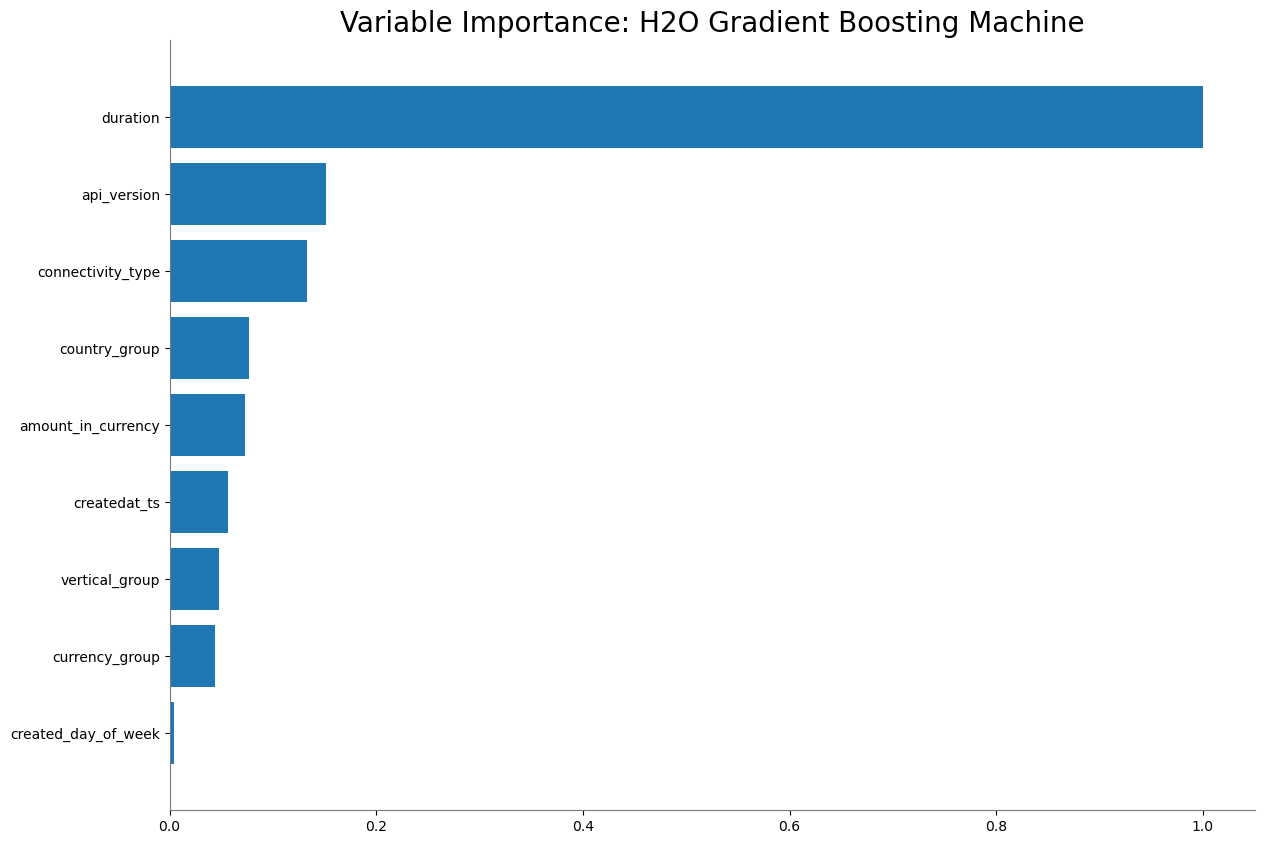

<Figure size 640x480 with 0 Axes>

In [4]:
loaded_model.varimp_plot()

This plot should be used as a guide and treated with caution when correlation exists between the predictors. Duration clearly dominates as the biggest driver of payments executing or failing. Partial dependence plots below help us to uncover what direction the effect of duration has, e.g is a longer duration a driver of failed payments. **Note partial dependence plots are also biased by multicollinearity**.

## Partial Dependence Plots

The partial dependence plots show the marginal effect, adjusting for confounding variables. The value displayed broadly corresponds to the probability of a failed payment, with a 95% confidence interval.

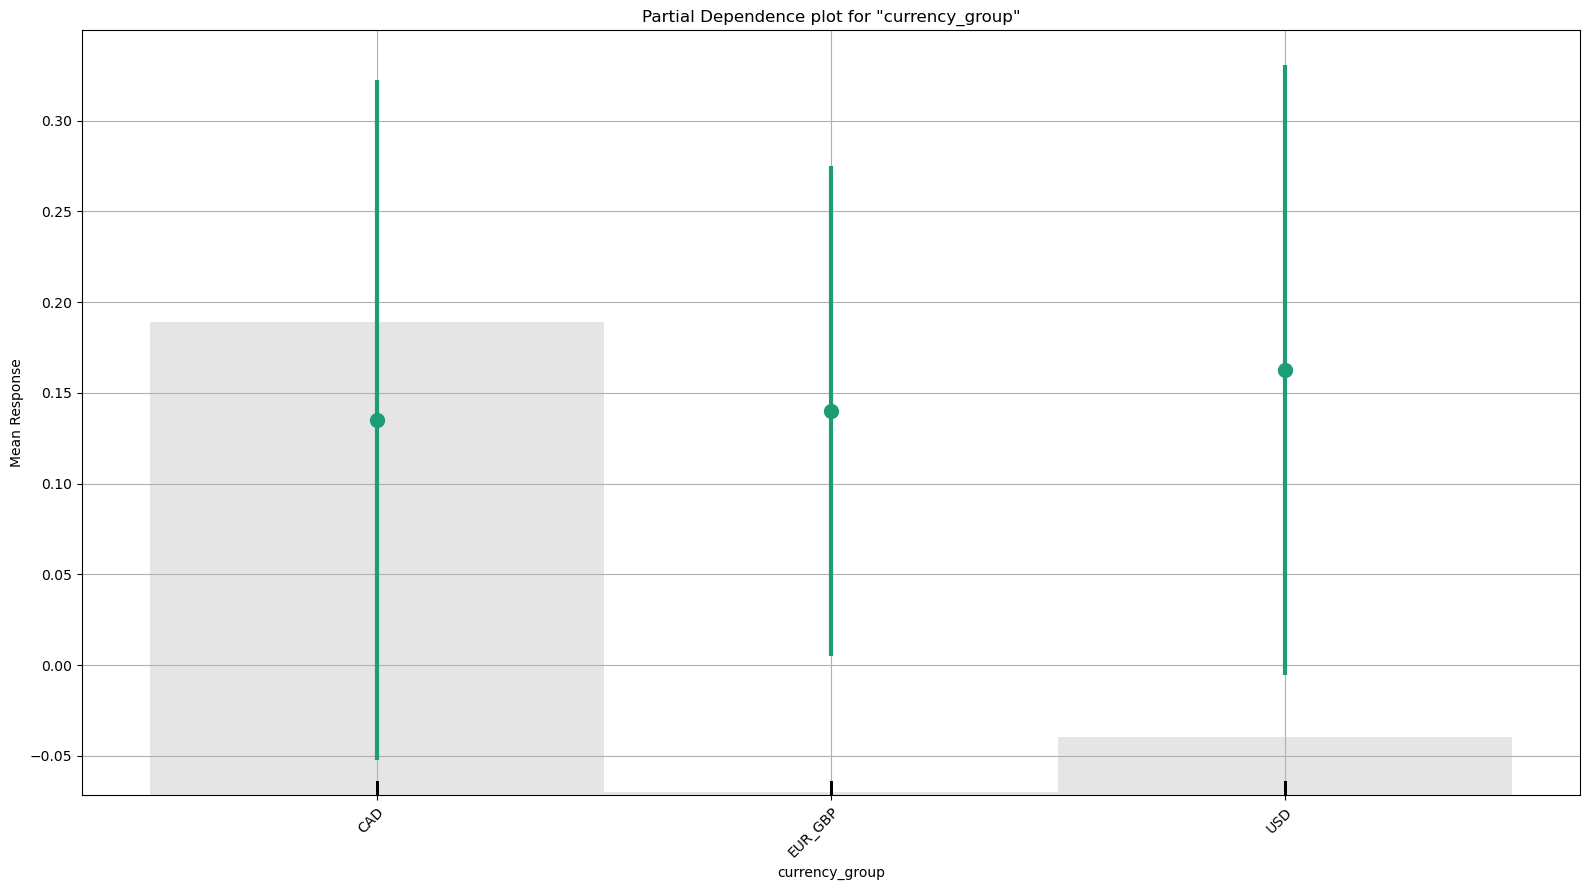

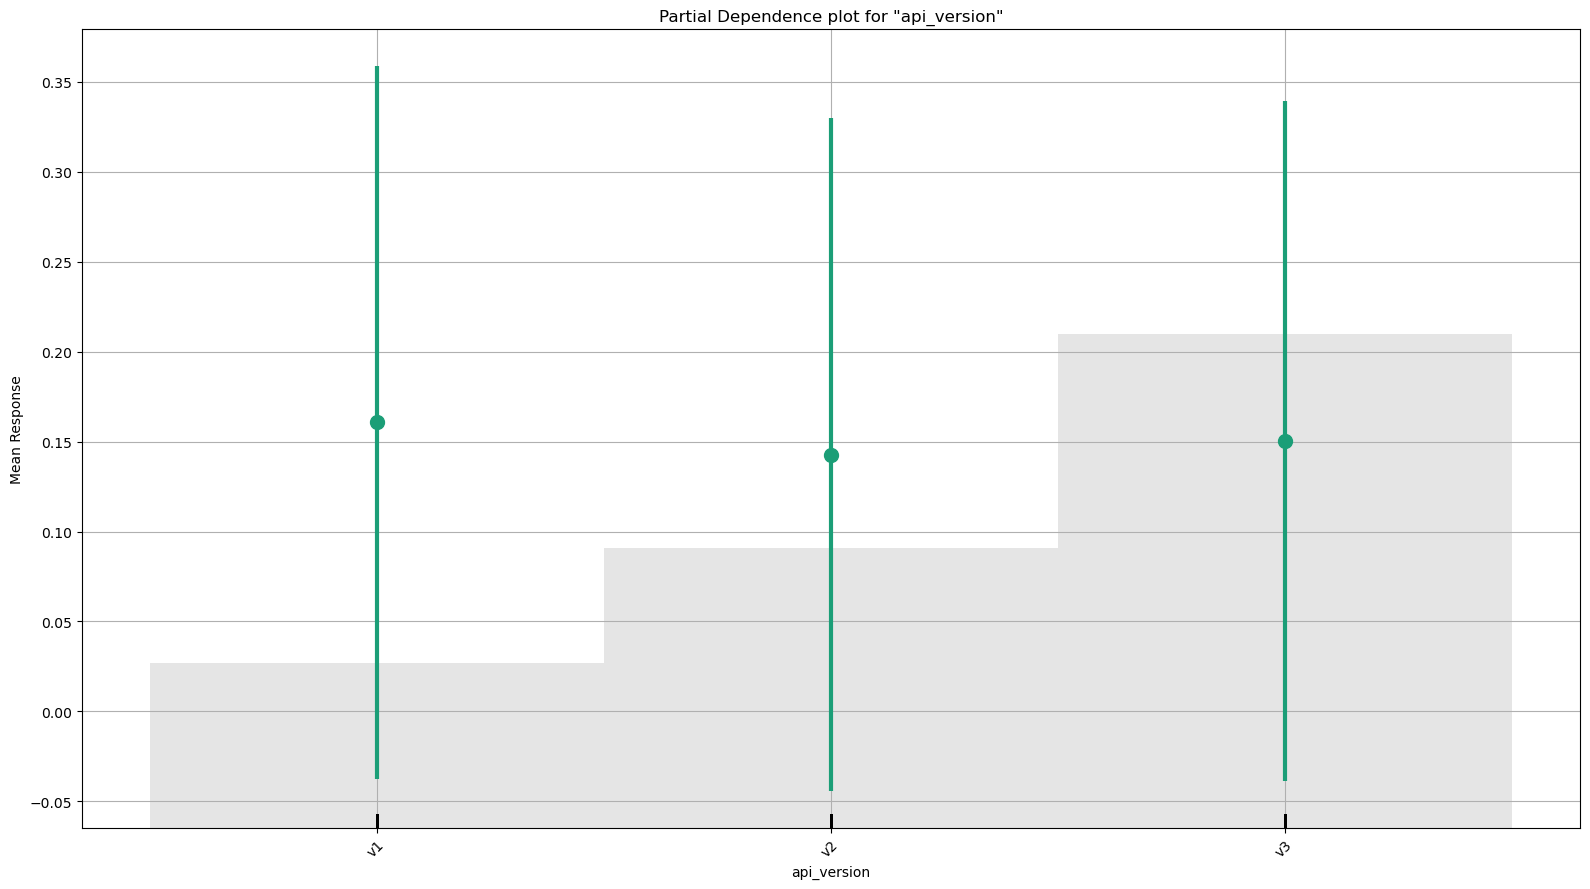

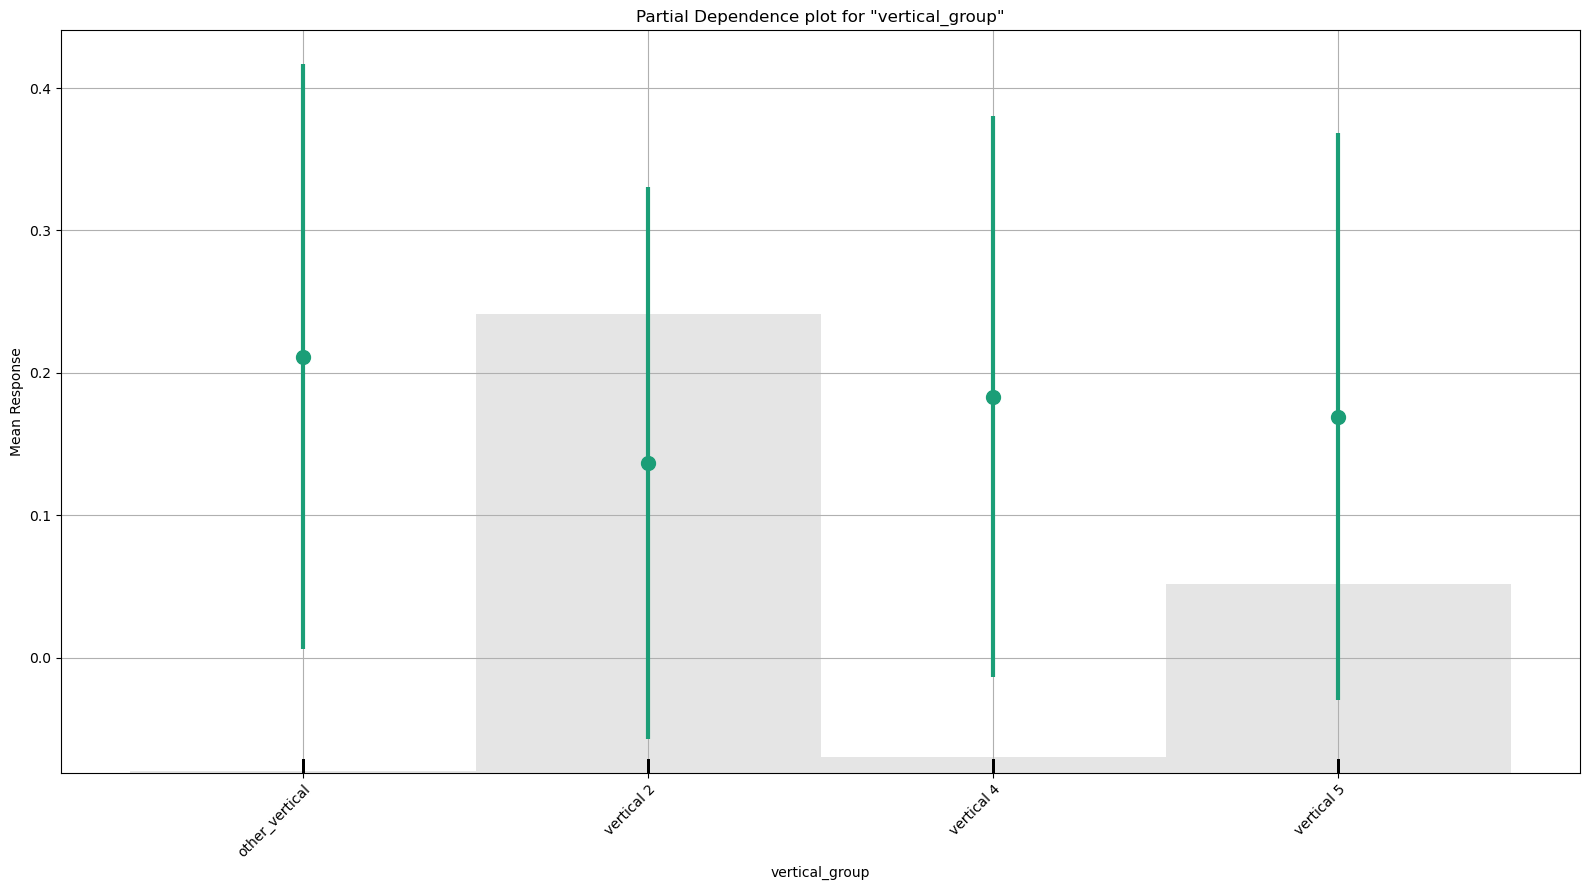

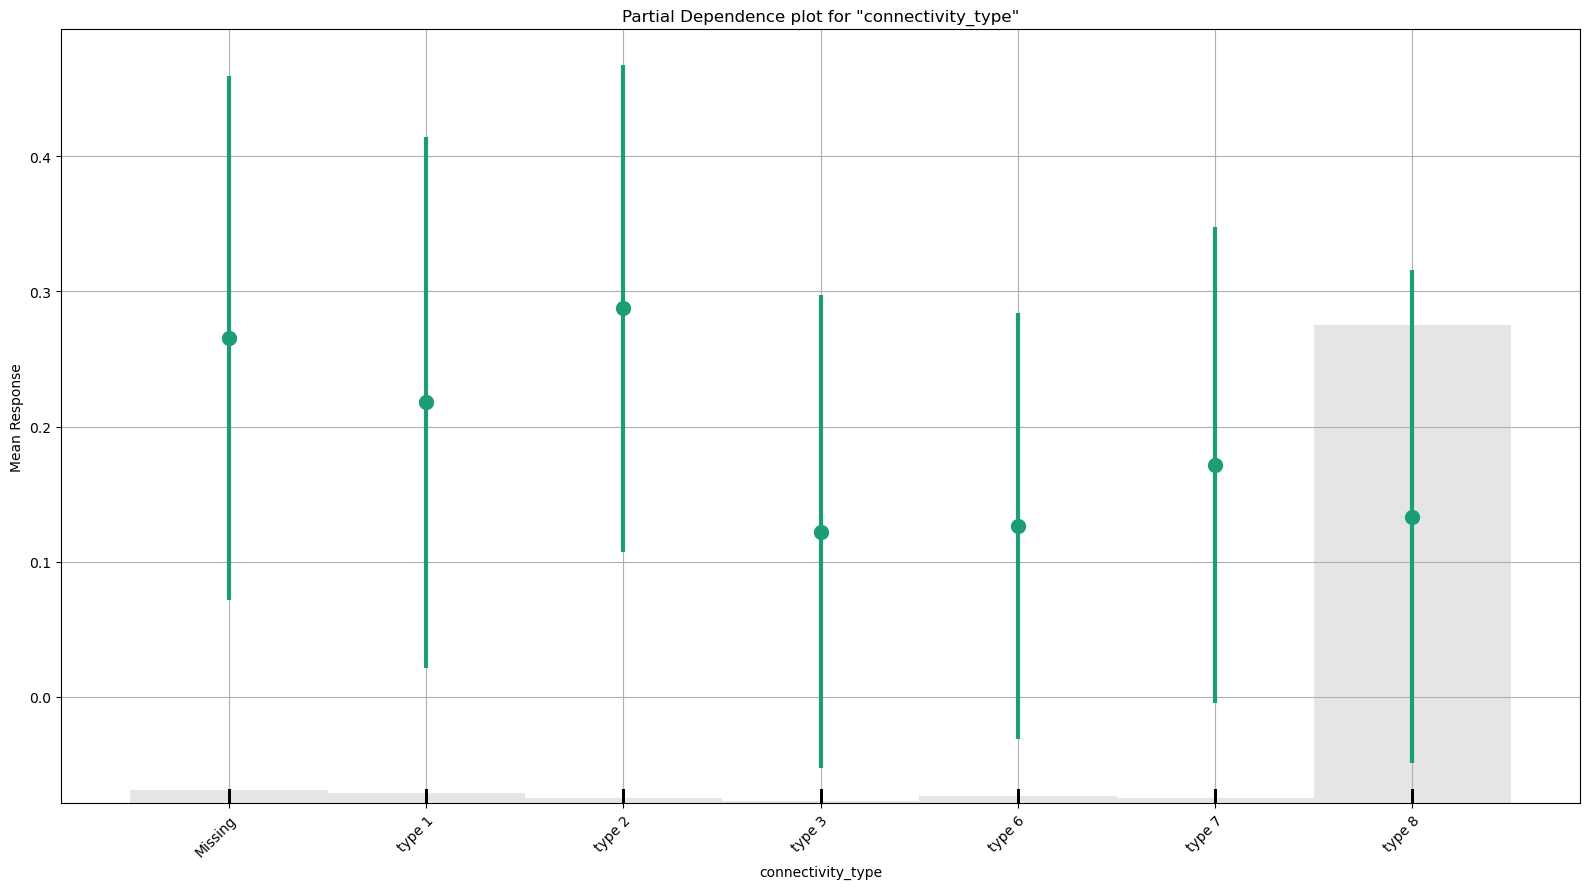

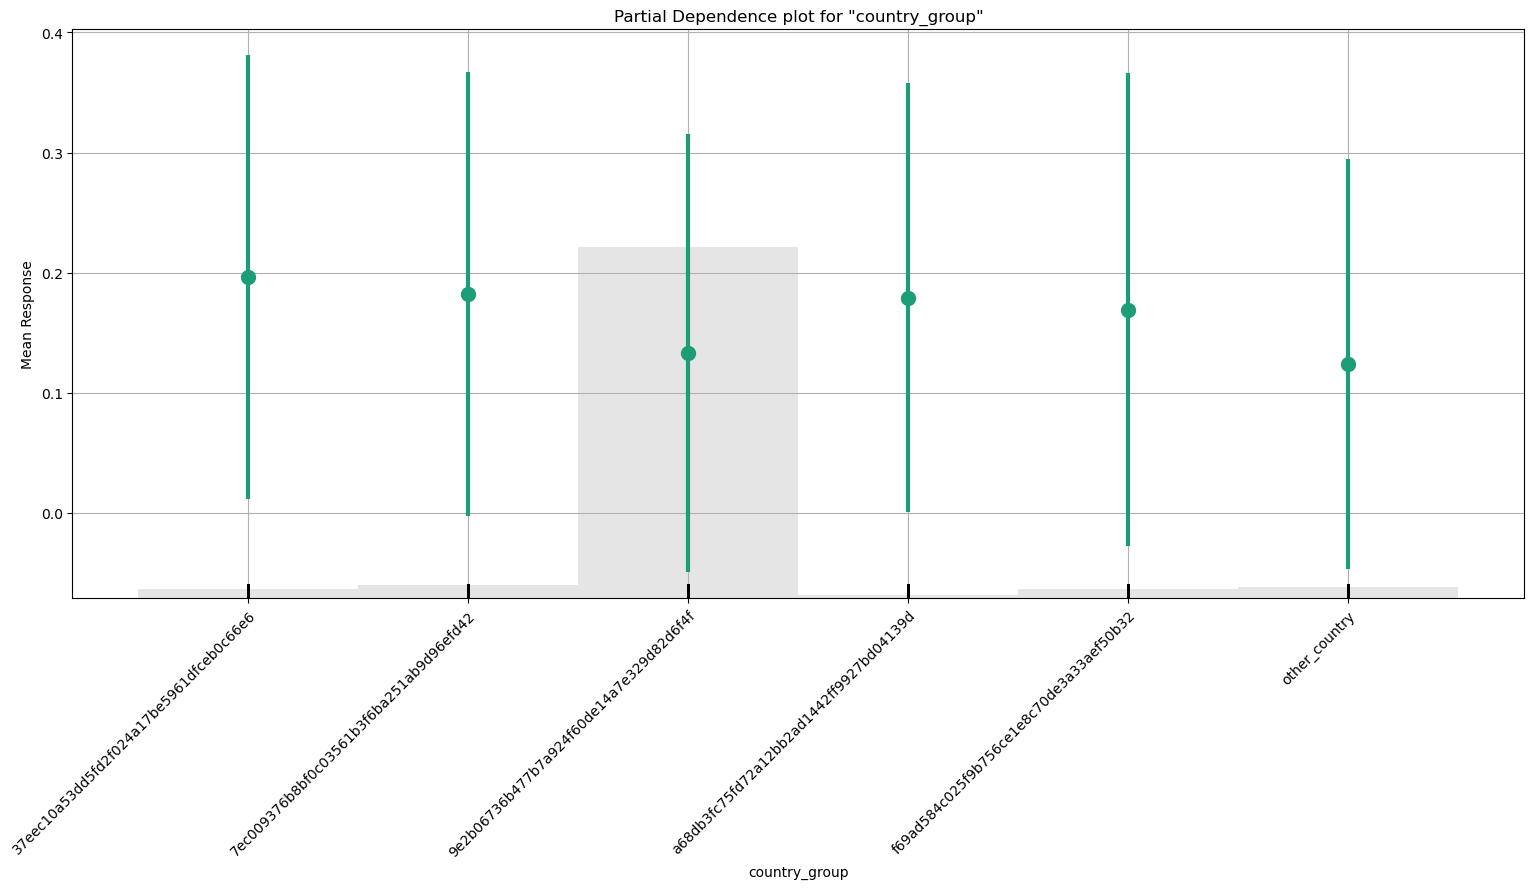

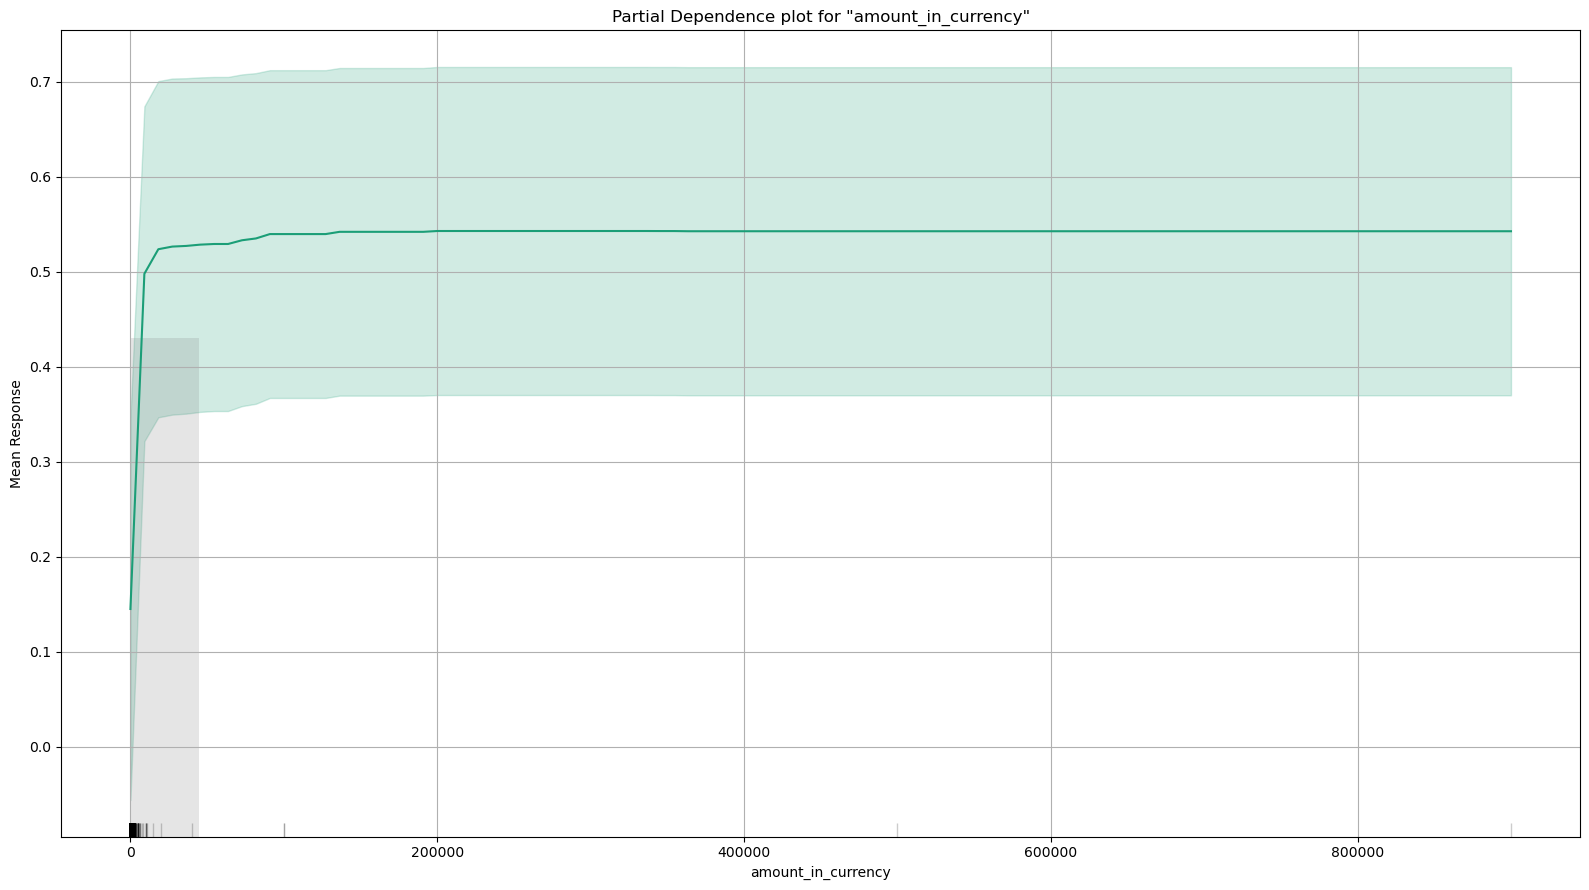

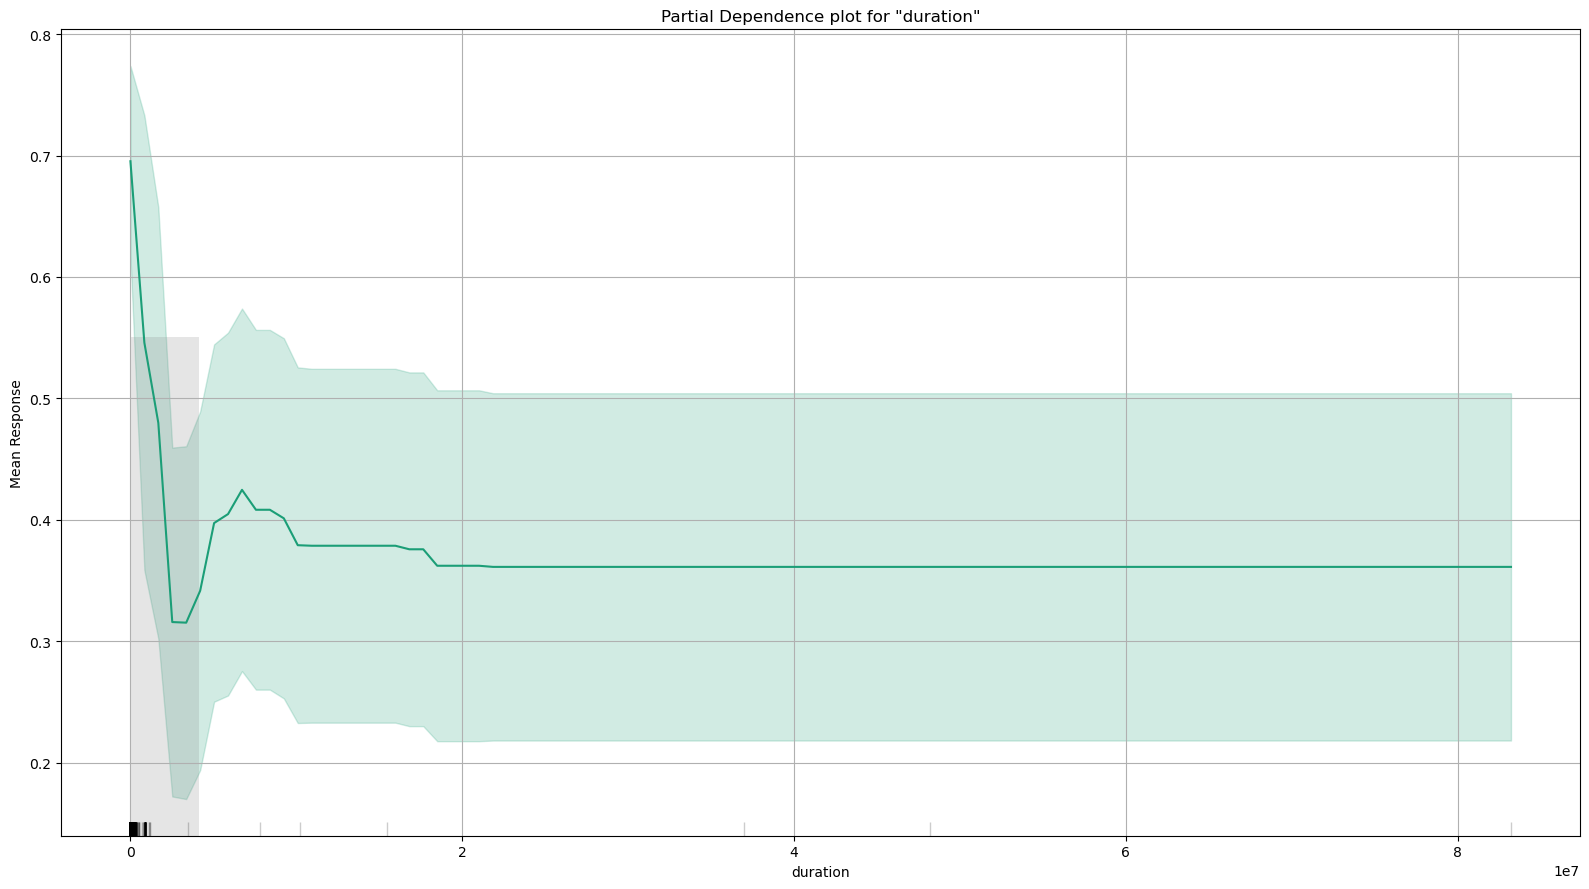

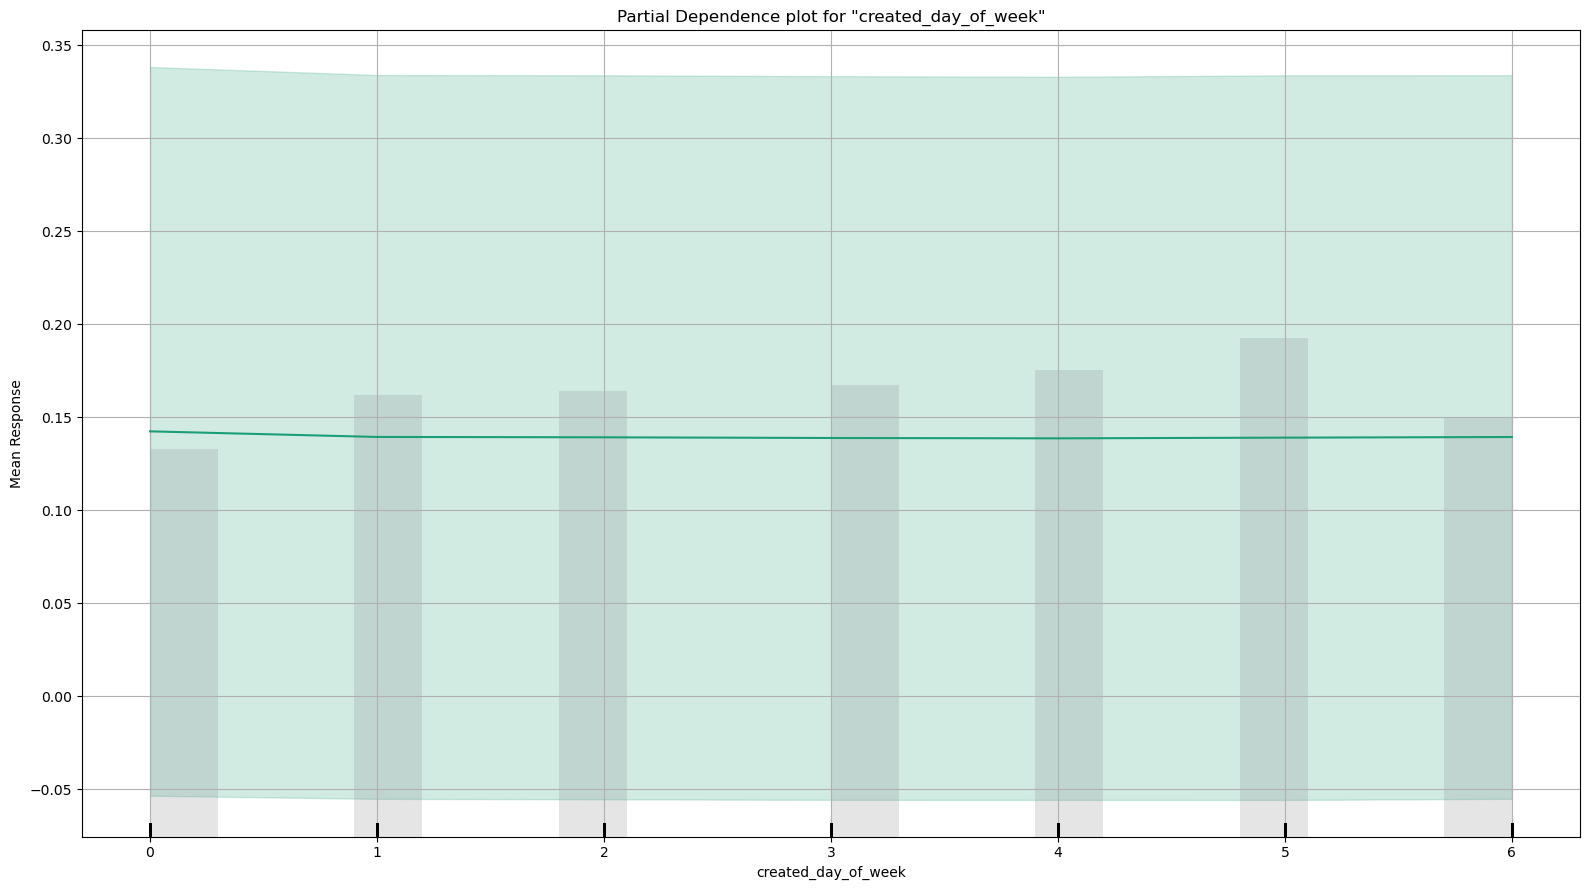

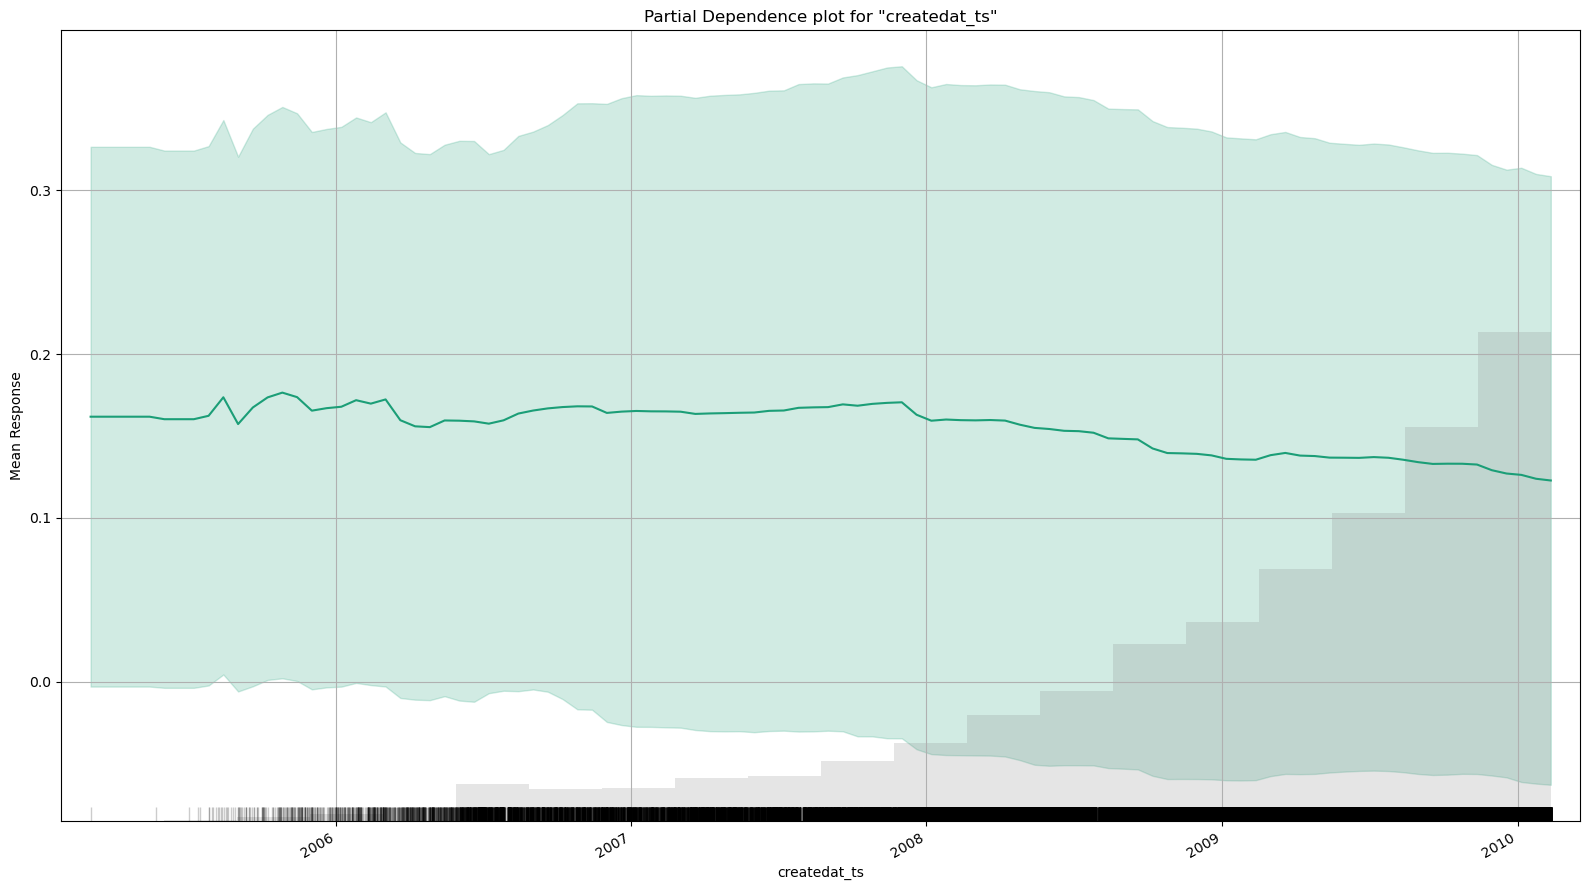

In [15]:
for predictor in predictors:
    loaded_model.pd_plot(test, column=predictor)

## SHAP summary plot

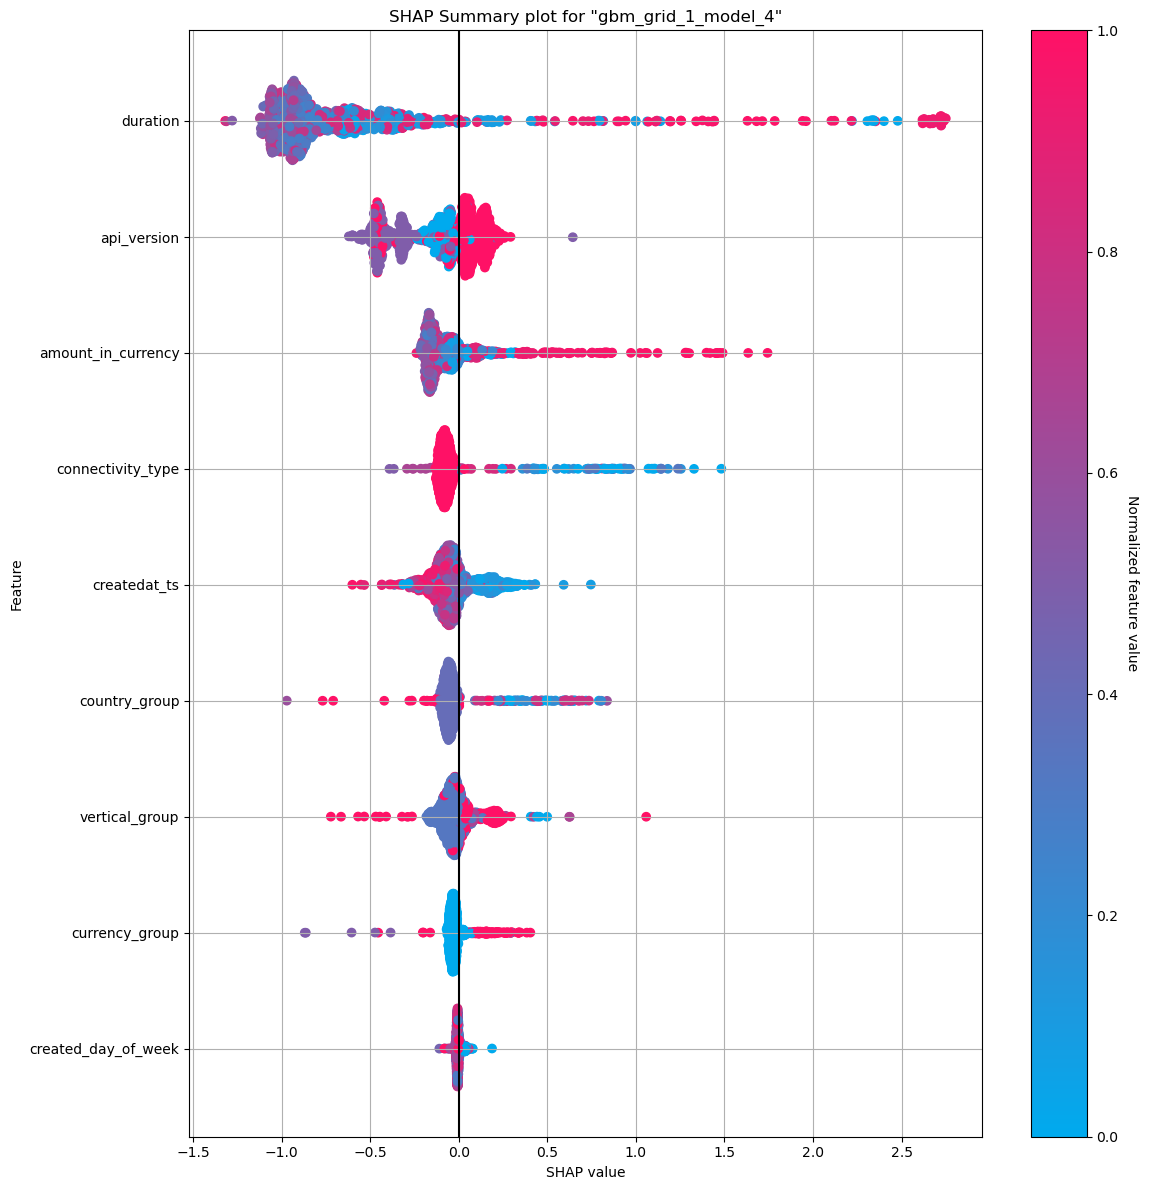

In [5]:
loaded_model.shap_summary_plot(test)

The SHAP summary plot shows the influence of each row on the predicted probability. This is appropriate when correlation exists amongst predictors. A data point for a given feature with value of 0 means the feature had no impact on its predicted value. A large value corresponds to a large influence on the prediction being 'failed' and large negative value means a large influence the predicted value is 'executed'. The colour code shows high or low values for continuous variables and different categories for categorical variables, which can be unpicked by looking in combination with the partial dependence plots.

## Evaluation Metrics

In [13]:
os.chdir("evaluation")
performance = pd.read_csv("performance.csv")
performance

,Metric,Value
0,train_auc_roc,0.863384
1,test_auc_roc,0.858778
2,train_auc_pr,0.743902
3,test_auc_pr,0.734907
4,train_precision_class1,1.000000
5,train_precision_class0,0.969450
6,test_precision_class1,1.000000
7,test_precision_class0,0.970963
8,train_recall_class1,1.000000
9,train_recall_class0,0.030836


In [14]:
os.getcwd()

'/Users/lukeday/Documents/GitHub/repos/Payments/evaluation'

The performance metrics indicate a good discriminatory ability on the test set. Given that the data is imbalanced, AUC PR, precision and recall are appropriate, and accuracy may be misleading.